In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
%matplotlib inline

from data_builder import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pickle
from model_builder import get_models

In [29]:
def relativity(num_samples, T_max, dt, noise_std=0, seed=3, type=1):

    def hamiltonian_fn(coords,t):
        q,p = np.split(coords,2)
        c = 1
        m = 1
        if type == 1:
            omega = 1.2
            delta = 0
            gamma = 0.2
            alpha = 1
            beta = 1
        if (type == 2) or (type==3):
            alpha = -1
            beta = 1
            omega = 1.2
            delta = 0
            gamma = 10
        H = c * np.sqrt(p ** 2 + m ** 2 * c ** 2) + alpha * (q ** 2) / 2 + beta * (q ** 4) / 4 - q * gamma * sin(
        omega * t)

        return H
    #autograd slows the computation for long trajectories
    def dynamics_fn(t, coords):
        q,p = np.split(coords,2)

        c = 1
        m = 1

        if type == 1:
            omega = 1.2
            delta = 0
            gamma = 0.2
            alpha = 1
            beta = 1

        if (type == 2) or (type==3):
            alpha = -1
            beta = 1
            omega = 1.2
            delta = 0
            gamma = 10

        xdot = c * p * (p ** 2 + (m ** 2) * (c ** 2)) ** (-.5)
        pdot = -alpha * q - beta * q ** 3 - delta * xdot + gamma * np.sin(omega * t)

        S = np.concatenate([xdot, pdot], axis=-1)
        return S

    def get_trajectory(t_span=[0, T_max], timescale=dt):
        t_eval = np.arange(t_span[0], t_span[1], timescale)
        y0 = np.random.uniform(0,3,size=2)
        if type == 2:
            # y0 = [0,0.9]#np.random.rand(2) * 2 - 1
            y0 = [0., 0.]
            omega = 1.2
            dt_per_period = 100
            period = 2 * np.pi / omega
            dt = 2 * np.pi / omega / dt_per_period
            t_span = [0, 1000*period]
            t_eval = np.arange(0, 1000*period, dt)
        if type == 3:
            # y0 = np.random.rand(2) * 2 - 1
            y0 = [0., 0.]
            omega = 1
            dt_per_period = 100
            period = 2 * np.pi / omega
            dt = 2 * np.pi / omega / dt_per_period
            t_span = [0, T_max]
            t_eval = np.arange(0, T_max, dt)
        spring_ivp = rk(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval,rtol=1e-10)
        q, p = spring_ivp['y'][0], spring_ivp['y'][1]
        dydt = [dynamics_fn(t_eval[i], y) for i, y in enumerate(spring_ivp['y'].T)]
        dydt = np.stack(dydt).T
        dqdt, dpdt = np.split(dydt, 2)

        # add noise
        q += np.random.randn(*q.shape) * noise_std
        p += np.random.randn(*p.shape) * noise_std
        return q, p, dqdt, dpdt, t_eval

    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    ssr = 1  # int(srate / dt)
    energies = []
    tvalues = []
    for s in range(num_samples):
        x, y, dx, dy, t = get_trajectory()
        x = x[::ssr]
        y = y[::ssr]
        dx = dx[::ssr]
        dy = dy[::ssr]
        xs.append(np.stack([x, y]).T)
#         energies.append([hamiltonian_fn(xs[-1][i], t[i]) for i in range(len(xs[-1]))])
        dxs.append(np.stack([dx, dy]).T)
        tvalues.append(t)

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()
#     data['energy'] = np.concatenate(energies)
    data['tvalues'] = np.concatenate(tvalues)
    return data

In [30]:
test_data = relativity(1,1,0.1,type=2)

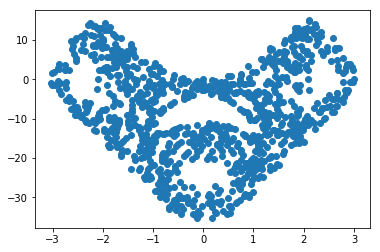

In [31]:
pstep = 100
plt.scatter(test_data['x'][::pstep,0],test_data['x'][::pstep,1])

In [32]:
def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        omega = 1.2
        period = 2 * np.pi / omega
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.tensor( np.mod(t,period), requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)
def test_model(model_name,model):
    # Each epoch has a training and validation phase
    q = test_data['x']
    t = test_data['tvalues']
#     q.requires_grad = True
#     tevals.requires_grad = True

    qinit = q[0]
    omega = 1.2
    dt_per_period = 1000
    period = 2 * np.pi / omega
    dt = 2 * np.pi / omega / dt_per_period
    preds = integrate_model(model,[0,10000],qinit.ravel(),t_eval=np.arange(0, 10000, dt)).y
    main_pred[model_name].append((preds.T,q))
    





In [33]:
# model_ft = HNN(2, 200, 1, 0.01)
main_pred={'TDHNN4':[]}

model_nms = list(main_pred.keys())
for model_name in model_nms:
    model_type = torch.load(f'relativity_2/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [34]:
pstep =1000

In [35]:
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})
sns.set_palette("Accent")


(0.0, 1.0, 0.0, 1.0)

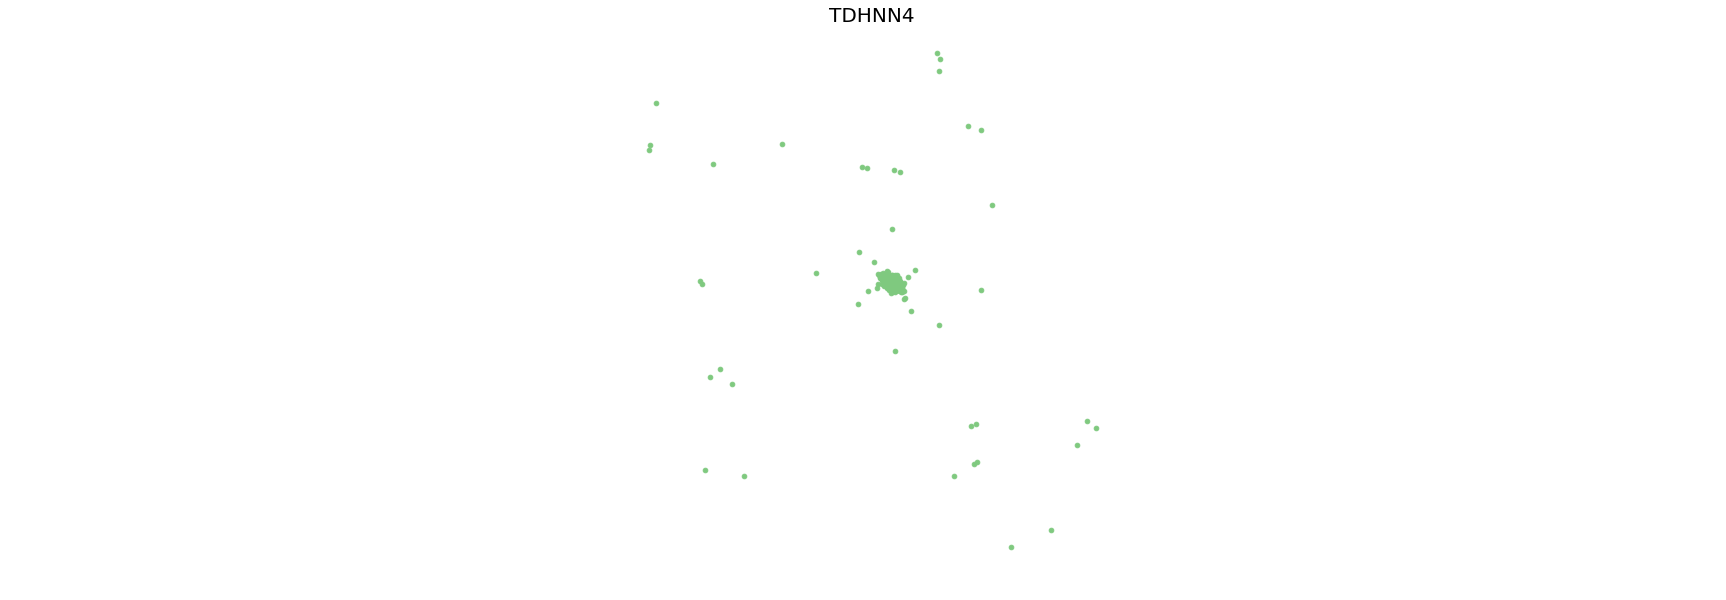

In [37]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
# plt.figure(figsize=(15,10))

# ax[0].scatter(main_pred['baseline'][0][0][::pstep,0],main_pred['baseline'][0][0][::pstep,1],label='predicted')
# ax[0].set_title('Baseline NN')

ax[1].scatter(main_pred['TDHNN4'][0][0][::pstep,0],main_pred['TDHNN4'][0][0][::pstep,1],label='predicted')
ax[1].set_title('TDHNN4')

# ax[2].scatter(main_pred['TDHNN'][0][0][::pstep,0],main_pred['TDHNN'][0][0][::pstep,1],label='predicted')
# ax[2].set_title('TDHNN')

# ax[2].scatter(test_data['x'][::pstep,0],test_data['x'][::pstep,1],c='black',label='ground truth')
# ax[2].set_title('Ground Truth')
# ax[2].set_xlim([-2,2])
# ax[2].set_ylim([-1.2,1.2])

# ax[1].set_xlim([-2,2])
# ax[1].set_ylim([-1.2,1.2])

# ax[0].set_xlim([-2,2])
# ax[0].set_ylim([-1.2,1.2])

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
# plt.savefig('main_fig.pdf',dpi=2400,bbox_inches='tight')

Text(0.5, 1.0, 'Predicted')

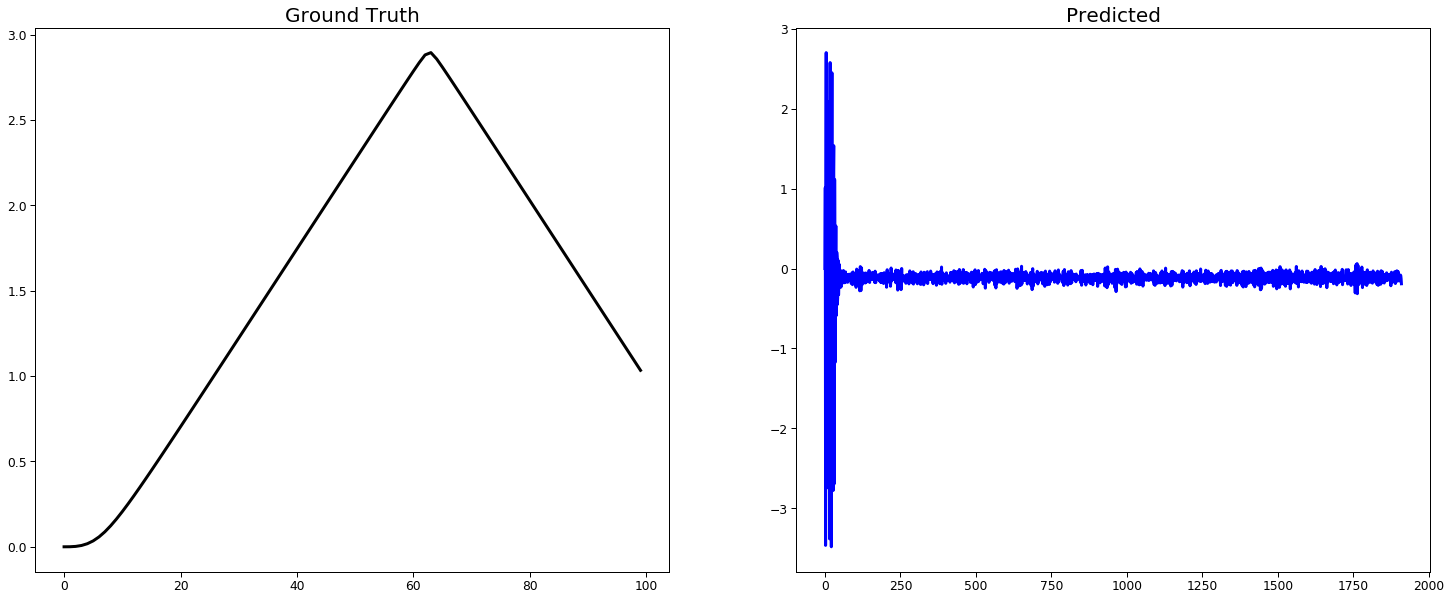

In [39]:
fig,ax = plt.subplots(1,2,figsize=(25,10))
# plt.figure(figsize=(15,10))
ax[0].plot(test_data['x'][:100,0],c='black',label='ground truth')
ax[0].set_title('Ground Truth')

# ax[0].plot(main_pred['baseline'][0][0][:100,0],c='blue',label='predicted')
# ax[0].set_title('Predicted')


ax[1].plot(main_pred['TDHNN4'][0][0][::pstep,0],c='blue',label='predicted')
ax[1].set_title('Predicted')



Text(0.5, 1.0, 'Ground Truth')

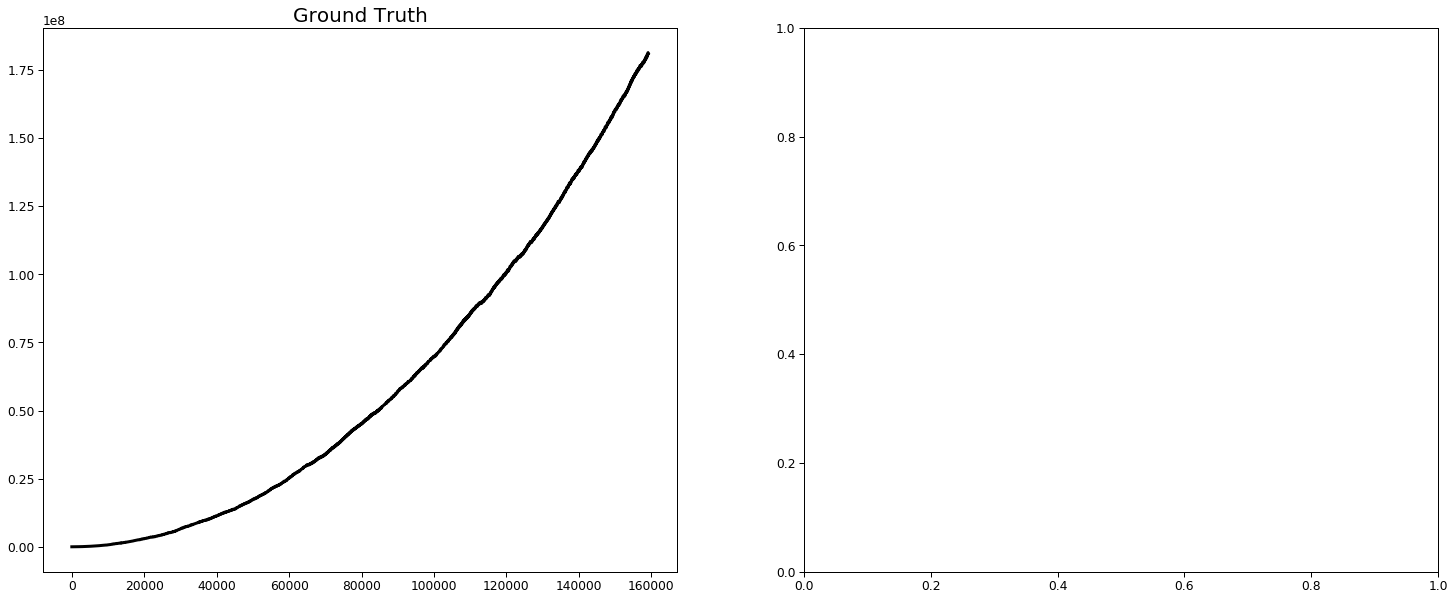

In [14]:
fig,ax = plt.subplots(1,2,figsize=(25,10))
# plt.figure(figsize=(15,10))
ax[0].plot(np.mean(np.square(test_data['x']-main_pred['TDHNN4'][0][0]),1),c='black',label='ground truth')
ax[0].set_title('Ground Truth')

# ax[1].plot(main_pred['TDHNN4'][0][0][::pstep,0],c='blue',label='predicted')
# ax[1].set_title('Predicted')



In [41]:
pstep

100

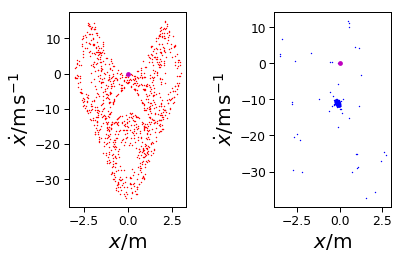

In [42]:
# The animation
pstep=100
fig, ax = plt.subplots(nrows=1,ncols=2)
x = test_data['x'][:,0]
xdot = test_data['x'][:,1]
# Poincaré section plot
ax4 = ax[0]
ax4.set_xlabel(r'$x / \mathrm{m}$')
ax4.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ax4.scatter(x[::pstep], xdot[::pstep], s=2, lw=0, c='r')
scat1 = ax4.scatter([0], [0], lw=0, c='m')

x = main_pred['TDHNN4'][0][0][:,0]
xdot = main_pred['TDHNN4'][0][0][:,1]
# Poincaré section plot
ax4 = ax[1]
ax4.set_xlabel(r'$x / \mathrm{m}$')
ax4.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ax4.scatter(x[::1000], xdot[::1000], s=2, lw=0, c='b')
scat1 = ax4.scatter([0], [0], lw=0, c='m')


plt.tight_layout()

# def animate(i):
#     """Update the image for iteration i of the Matplotlib animation."""

#     ln1.set_data(x[i], V(x[i]))
#     ln2.set_data(t[:i+1], x[:i+1])
#     ax2.set_xlim(t_trans, t[i])
#     ln3.set_data(x[:i+1], xdot[:i+1])
#     if not i % pstep:
#         scat1.set_offsets(X[i])
#     return

# anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=1)

# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# anim.save('duffing.mp4', writer=writer)


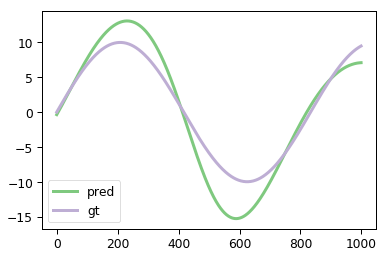

In [45]:
tevals = torch.arange(0,2*np.pi,2*np.pi/1000)
tevals.to('cpu')
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_F(tevals.reshape(-1,1))
plt.plot(f.detach().numpy(),label='pred')
plt.plot(10*np.sin(1.2*tevals.detach().numpy()),label='gt')
plt.legend()

In [44]:
model_type.get_D()

Parameter containing:
tensor([[-1.3561]], requires_grad=True)

In [19]:
q=q.to(device)
q=q.float()
q.requires_grad=True
tevals.to(device)
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_D()
print(f,q[:,1],(f*q[:,1]))
plt.plot((f[0]*q[:,1]).detach().numpy(),label='pred')
#     plt.plot(-0.3*q[:,1].detach().numpy(),label='gt')
    break

NameError: name 'data_dict' is not defined

In [46]:
q = torch.arange(-5,5,0.1)
qd = torch.arange(-5,5,0.1)
q= q.float()
qd = qd.float()
q.requires_grad = True
qd.requires_grad = True
qvec = torch.cat([q.reshape(-1,1),qd.reshape(-1,1)],1)
f = model_type.get_H(qvec)


In [47]:
qm,qdm = torch.meshgrid(q,qd)

In [48]:
f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))

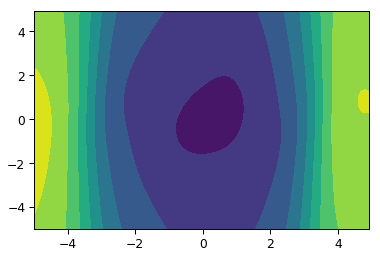

In [49]:
plt.contourf(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy())

In [47]:

model_type.f3.weight

Parameter containing:
tensor([[-2.8749e-02, -3.5966e-02,  6.8856e-02,  5.3383e-02,  4.3093e-02,
         -5.4524e-02, -1.0189e-02, -1.4727e-02,  7.1466e-02, -4.2445e-02,
         -4.4129e-02,  1.0007e-01,  4.1829e-02, -1.1200e-01, -3.0512e-02,
          8.2839e-02,  1.3796e-01, -8.6580e-02,  9.0889e-03,  6.0140e-02,
         -3.4457e-02, -5.2510e-04,  5.2127e-04, -7.8671e-03,  6.1372e-02,
          1.0587e-03, -1.0371e-01, -9.7648e-02,  8.9857e-02, -2.5417e-03,
          1.3451e-01,  1.5510e-02, -1.7066e-02,  6.9484e-02,  2.9604e-02,
         -1.3987e-02,  3.1895e-02,  1.1272e-01, -2.5302e-02,  4.0529e-02,
         -1.1893e-01, -4.2077e-02, -1.1450e-01,  1.6553e-01,  1.2852e-01,
          2.1697e-01, -5.6715e-02, -1.4004e-01,  2.9060e-02, -8.8631e-02,
          3.2727e-02, -2.1741e-03,  9.1915e-02,  6.5766e-03, -8.8785e-04,
          6.5643e-04, -6.3300e-02,  1.2166e-02, -5.3498e-02,  6.5754e-04,
         -1.5640e-02, -4.0288e-03, -3.3099e-02,  3.3492e-02,  1.9404e-04,
          1.0777